---

# Gaussian Mixture Model (GMM) Usage, Analysis and Visualization

This notebook demonstrates how to generate synthetic data, fit a Gaussian Mixture Model (GMM) using an Expectation-Maximization (EM) algorithm, inspect the learned parameters, and visualize both the clustering results and the per-sample probabilities. We will also generate new samples from the fitted model and analyze component probability distributions.

The notebook is organized into the following sections:

1. **Synthetic Data Generation and Initial Visualization:**  
   Create multiple data clusters using different sample sizes, centers, and covariance matrices.

2. **GMM Fitting and Evaluation:**  
   Convert data to tensors, initialize and fit the GMM, and compute predictions and log-likelihoods.

3. **Model Parameter Inspection:**  
   Print the weights, means, and covariances for each component to understand the model parameters.

4. **Visualization of Results:**  
   Plot the original data, per-sample log-likelihood, GMM clustering results, and generated samples.

5. **Component Probability Analysis:**  
   Visualize the probability distributions for each GMM component (both for the observed data and generated samples).

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('../')

from tgmm import GaussianMixture, GMMInitializer, dynamic_figsize, plot_gmm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
random_state = 0
np.random.seed(random_state)
torch.manual_seed(random_state)

if device == 'cuda':
    torch.cuda.manual_seed(random_state)
    print('CUDA version:', torch.version.cuda)
    print('Device:', torch.cuda.get_device_name(0))
else:
    print('Using CPU')

CUDA version: 12.4
Device: NVIDIA GeForce RTX 4060 Laptop GPU


---
## Synthetic Data Generation

The synthetic dataset is generated by combining four Gaussian components:

- **Component 1:** Centered at `[0, 2]` with spherical covariance.
- **Component 2:** Centered at `[2, -2]` with spherical covariance (fewer points).
- **Component 3:** Centered at `[0, 0]` with diagonal covariance.
- **Component 4:** Centered at `[2, 2]` with full covariance.

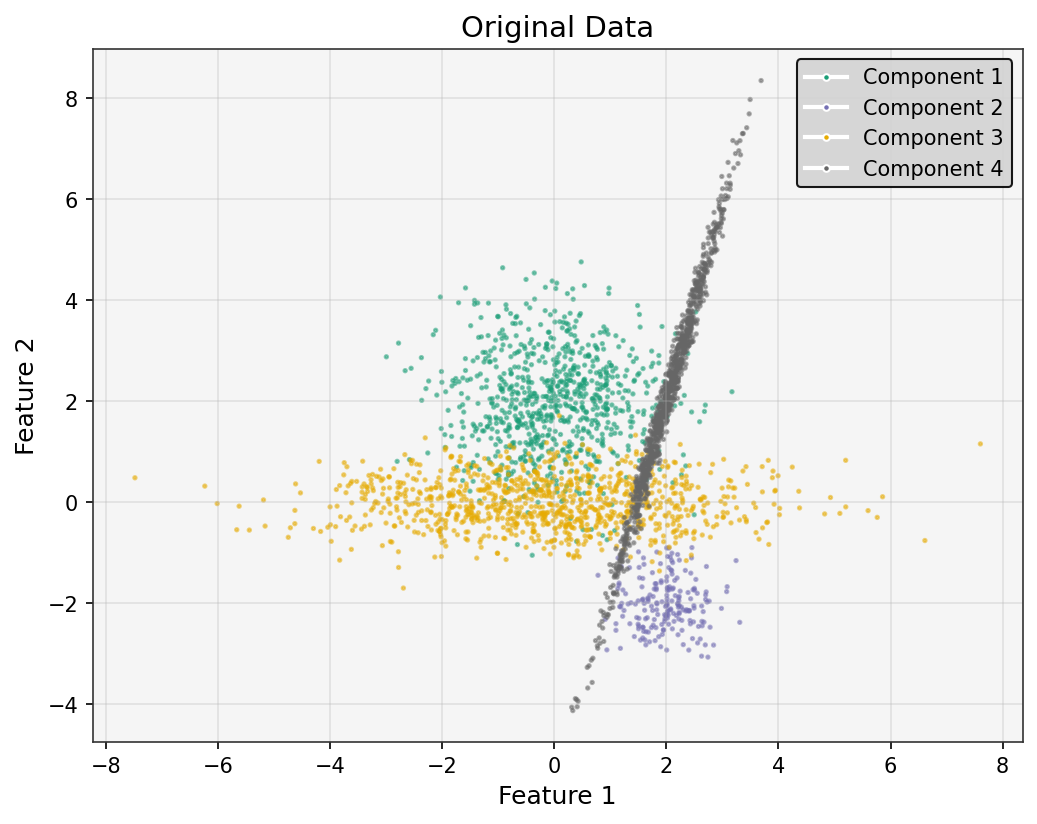

In [5]:
n_samples = [800, 200, 1000, 1000]
centers = [np.array([0, 2]),
           np.array([2, -2]),
           np.array([0, 0]),
           np.array([2, 2])]
covs = [
    1.0 * np.eye(2),                    # spherical covariance
    0.5 * np.eye(2),                    # spherical covariance, fewer points
    np.array([[2, 0], [0, 0.5]]),       # diagonal covariance
    np.array([[0.2, 0.5], [0.5, 2]])    # full covariance
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    samples = np.dot(np.random.randn(n, 2), cov) + center
    components.append(samples)

X = np.vstack(components)
labels = np.concatenate([i * np.ones(n) for i, n in enumerate(n_samples)])
legend_labels = [f'Component {i+1}' for i in range(len(n_samples))]

n_features = X.shape[1]
n_components = len(n_samples)

plot_gmm(X=X, labels=labels, title='Original Data', legend_labels=legend_labels)
plt.show()

---
## Fitting the Gaussian Mixture Model

This section converts the synthetic data (`X`) into a PyTorch tensor (`X_tensor`) and sets up the GMM with the following parameters:

- **n_components:** Number of clusters (set to 4).
- **covariance_type:** Using the 'full' covariance model.
- **Tolerance, regularization, and maximum iterations:** Set for a precise convergence.
- **Initialization:** Using random initialization with multiple random restarts (`n_init=5`).

The GMM is then fitted to the data via the EM algorithm. After fitting, we obtain:

- **Predicted Cluster Labels:** Using the `predict` method.
- **Per-Sample Log-Likelihoods:** Using the `score_samples` method.
- **Posterior Probabilities:** For each data sample across all components.
- **New Samples:** Generated from the fitted GMM, along with the corresponding component indices.

Diagnostic information such as mean log-likelihood, convergence status, and number of iterations is printed to verify the model's performance.


In [6]:
# Convert to tensor (if needed for further processing)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

n_components = 4

# Initialize the GMM
gmm = GaussianMixture(
    n_components=n_components,
    covariance_type='full',
    tol=1e-6,
    reg_covar=1e-10,
    max_iter=1000,
    init_params='random',
    cov_init_method='eye',
    weights_init=None,
    means_init=None,
    covariances_init=None,
    n_init = 5,
    random_state=None,
    warm_start=False,
    verbose=True,
    verbose_interval=100,
    device='cpu',
)
# Fit the GMM
gmm.fit(X_tensor)

# Get predictions
y_pred = gmm.predict(X_tensor)

# Compute per-sample log-likelihoods
log_probs = gmm.score_samples(X_tensor)

# Get probabilities for each sample for each component
probs = gmm.predict_proba(X_tensor)
probs = probs.detach()

# Generate new samples
n_samples_to_generate = len(X)
gmm_samples, gmm_labels = gmm.sample(n_samples_to_generate)
gmm_samples = gmm_samples.detach().cpu().numpy()
gmm_labels = gmm_labels.detach().cpu().numpy()

# Compute probabilities for each generated sample
generated_probs = gmm.predict_proba(torch.tensor(gmm_samples, dtype=torch.float32).to(device))
generated_probs = generated_probs.detach().cpu().numpy()

print('Mean per-sample log-likelihood:                        ', gmm.score(X_tensor))
print('Mean per-sample log-likelihood (torch.mean(log_probs)):', torch.mean(log_probs).item())
print('Lower bound:                                           ', gmm.lower_bound_)
for i in range(probs.shape[0]):
    assert np.isclose(torch.sum(probs[i]).item(), 1.0), f"Probabilities for sample {i} do not sum to 1"
print('Number of iterations:                                  ', gmm.n_iter_)
print('Converged:                                             ', gmm.converged_)


[InitRun 0] Iter 0, lower bound: -3.82055
[InitRun 0] Converged at iteration 74, lower bound=-3.15907
[InitRun 1] Iter 0, lower bound: -3.79736
[InitRun 1] Converged at iteration 55, lower bound=-3.15908
[InitRun 2] Iter 0, lower bound: -3.83079
[InitRun 2] Iter 100, lower bound: -3.23099
[InitRun 2] Converged at iteration 176, lower bound=-3.23034
[InitRun 3] Iter 0, lower bound: -3.71217
[InitRun 3] Converged at iteration 32, lower bound=-3.15908
[InitRun 4] Iter 0, lower bound: -3.81120
[InitRun 4] Converged at iteration 63, lower bound=-3.15907
Mean per-sample log-likelihood:                         -3.159071683883667
Mean per-sample log-likelihood (torch.mean(log_probs)): -3.159071683883667
Lower bound:                                            -3.159071683883667
Number of iterations:                                   74
Converged:                                              True


---
## Inspecting the Learned GMM Parameters

After fitting the model, we inspect the parameters learned by the GMM. For each component, the following are printed:

- **Weight:** The mixing proportion for the component.
- **Mean:** The estimated mean of the component.
- **Covariance:** The covariance matrix (or vector/scalar for other types) representing the spread of the component.


Component 1:
Weight:
0.06473217159509659
Mean:
[ 2.0007403 -2.0190282]
Covariance:
[[ 0.20824564 -0.00038021]
 [-0.00038021  0.24332365]]

Component 2:
Weight:
0.330704927444458
Mean:
[-0.14604712 -0.01135268]
Covariance:
[[ 3.9646182  -0.02417026]
 [-0.02417026  0.2430873 ]]

Component 3:
Weight:
0.2685912847518921
Mean:
[-0.01005521  1.9754888 ]
Covariance:
[[ 0.9500145  -0.03063332]
 [-0.03063332  0.9652317 ]]

Component 4:
Weight:
0.3359716534614563
Mean:
[2.0001736 2.004122 ]
Covariance:
[[0.28753313 1.0945222 ]
 [1.0945222  4.2454743 ]]


<Axes: title={'center': 'GMM'}, xlabel='Feature 1', ylabel='Feature 2'>

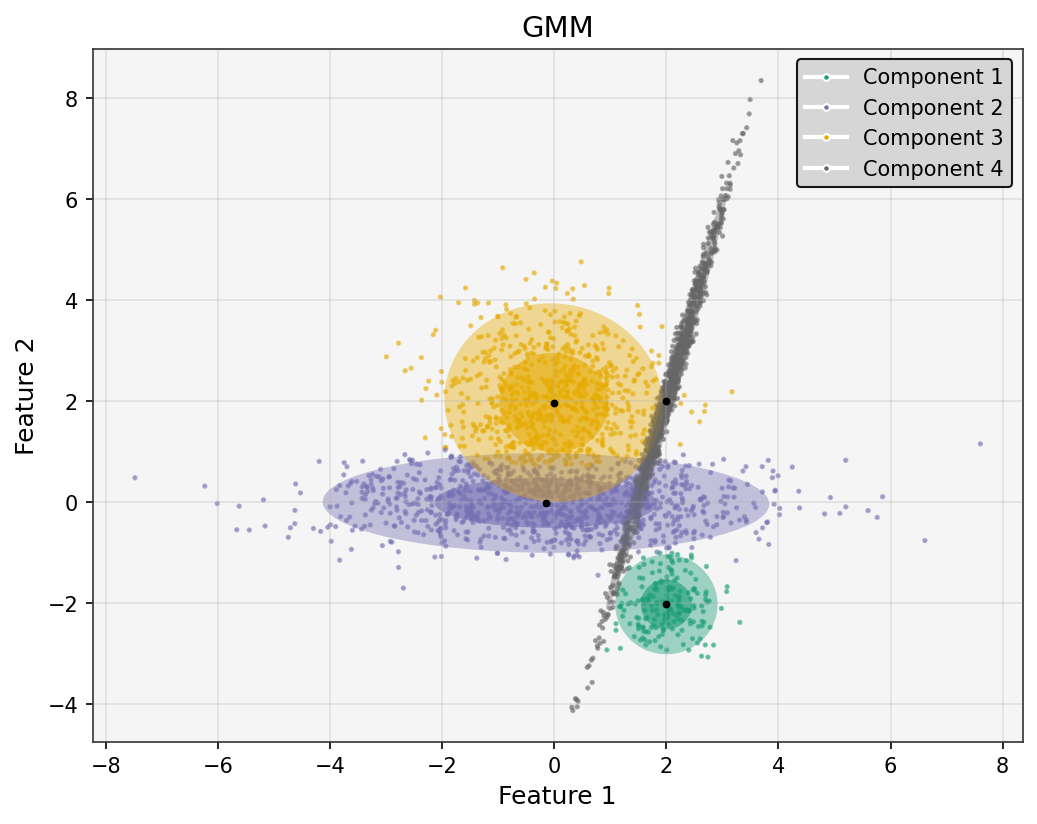

In [7]:
# weights, means, covariances of each component
for i in range(gmm.n_components):
    print(f'\nComponent {i+1}:')
    print('Weight:')
    print(gmm.weights_[i].item())
    print('Mean:')
    print(gmm.means_[i].detach().cpu().numpy())
    print('Covariance:')
    print(gmm.covariances_[i].detach().cpu().numpy())

plot_gmm(X=X, gmm=gmm, title='GMM', legend_labels=legend_labels)

---
## Visualization of Clustering and Generated Samples

In this section, we visualize several key results using our custom `plot_gmm` function:

1. **Per-Sample Log-Likelihood:**  
   A continuous scatter plot where each point is colored by its log-likelihood value. A colorbar is included to indicate the log-likelihood scale.

2. **GMM Clustering Results:**  
   A cluster plot where points are colored by their predicted labels. The plot also overlays the final GMM component means and ellipses representing covariance contours.

3. **Generated Samples:**  
   The new samples generated by the GMM are plotted along with the model's estimated parameters to evaluate how well the model reproduces the data distribution.


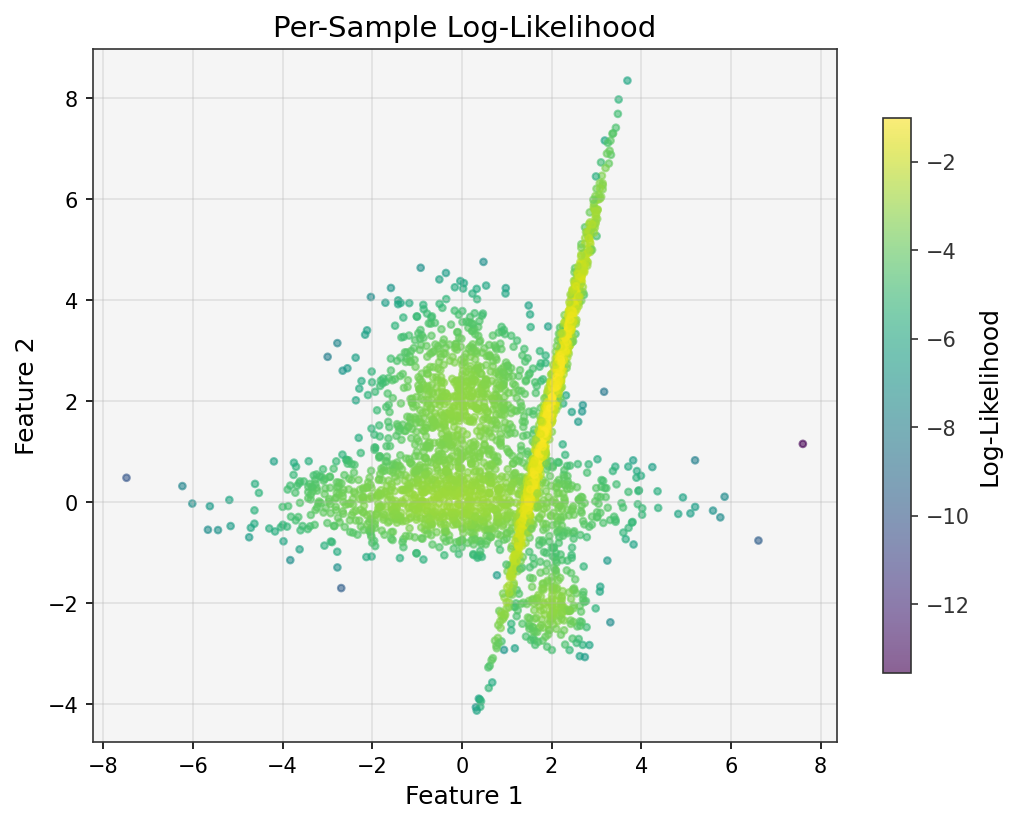

/home/asp/Downloads/HeaDS/TorchGMM/tgmm/plotting.py:432: UserWarning: No GMM or parameters provided. Inferring number of components from 'labels'. Cannot show ellipses.
  warnings.warn("No GMM or parameters provided. Inferring number of components from 'labels'. Cannot show ellipses.")
/home/asp/Downloads/HeaDS/TorchGMM/tgmm/plotting.py:501: UserWarning: Mode 'cluster' selected, but no GMM predictions available. Coloring by provided 'labels'.
  warnings.warn("Mode 'cluster' selected, but no GMM predictions available. Coloring by provided 'labels'.")


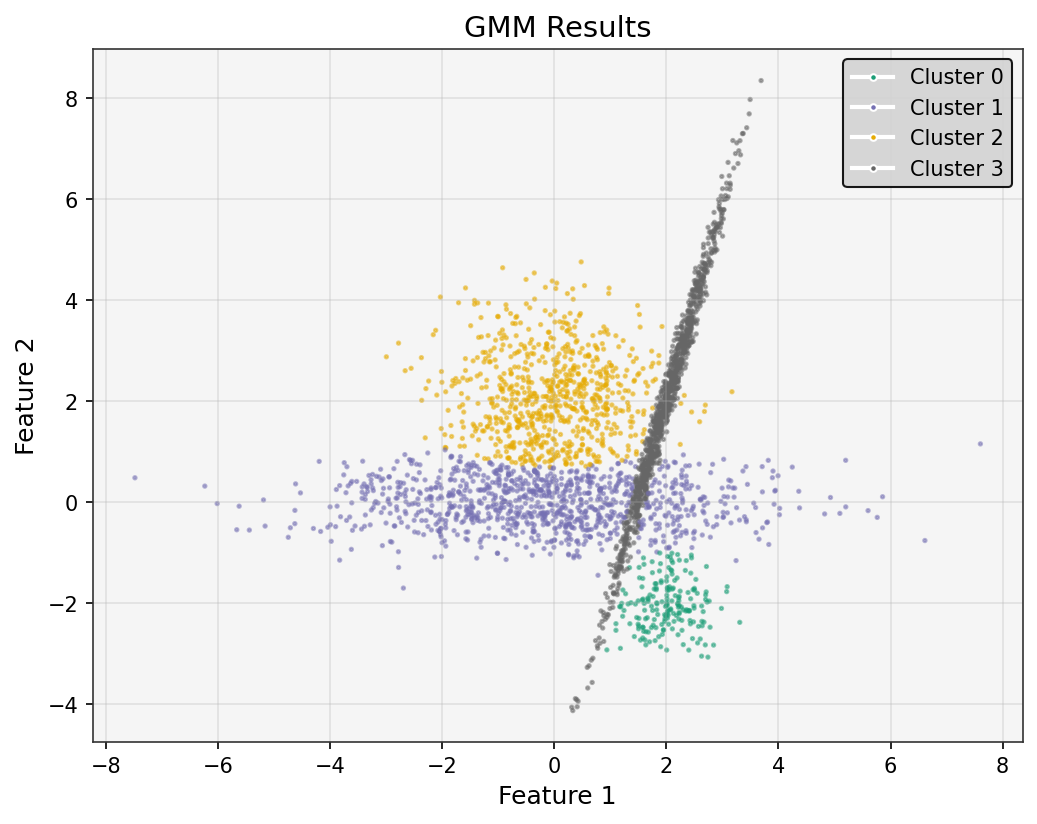

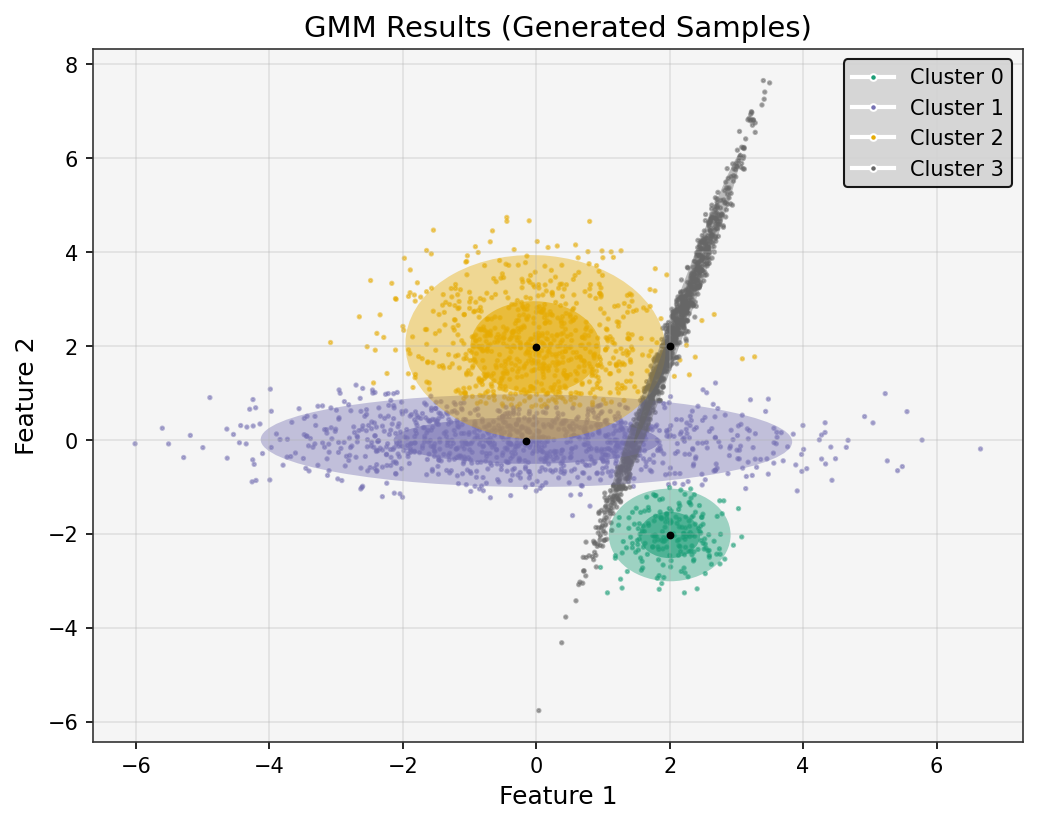

In [8]:
plot_gmm(X=X, title='Per-Sample Log-Likelihood', mode='continuous', color_values=log_probs, cmap_cont='viridis', cbar_label='Log-Likelihood')
plt.show()

plot_gmm(X=X, labels=y_pred, title='GMM Results', legend_labels=[f'Cluster {i}' for i in range(n_components)])
plt.show()

plot_gmm(X=gmm_samples, gmm=gmm, title='GMM Results (Generated Samples)')
plt.show()

---
## Visualizing Component Probability Distributions

Finally, we analyze the distribution of component responsibilities (i.e., the probability that each sample belongs to a particular component):

- **Observed Data:**  
  A grid of subplots is generated where each subplot shows the probability distribution for a single GMM component across the observed data. Each plot uses a continuous color scale (e.g., 'RdBu') with an associated colorbar.

- **Generated Samples:**  
  Similarly, we plot the component probability distributions for the generated samples, using a different colormap (e.g., 'PRGn').

These plots provide insight into how the GMM assigns probabilities to each data point and how well each component is represented in both the original and generated data.


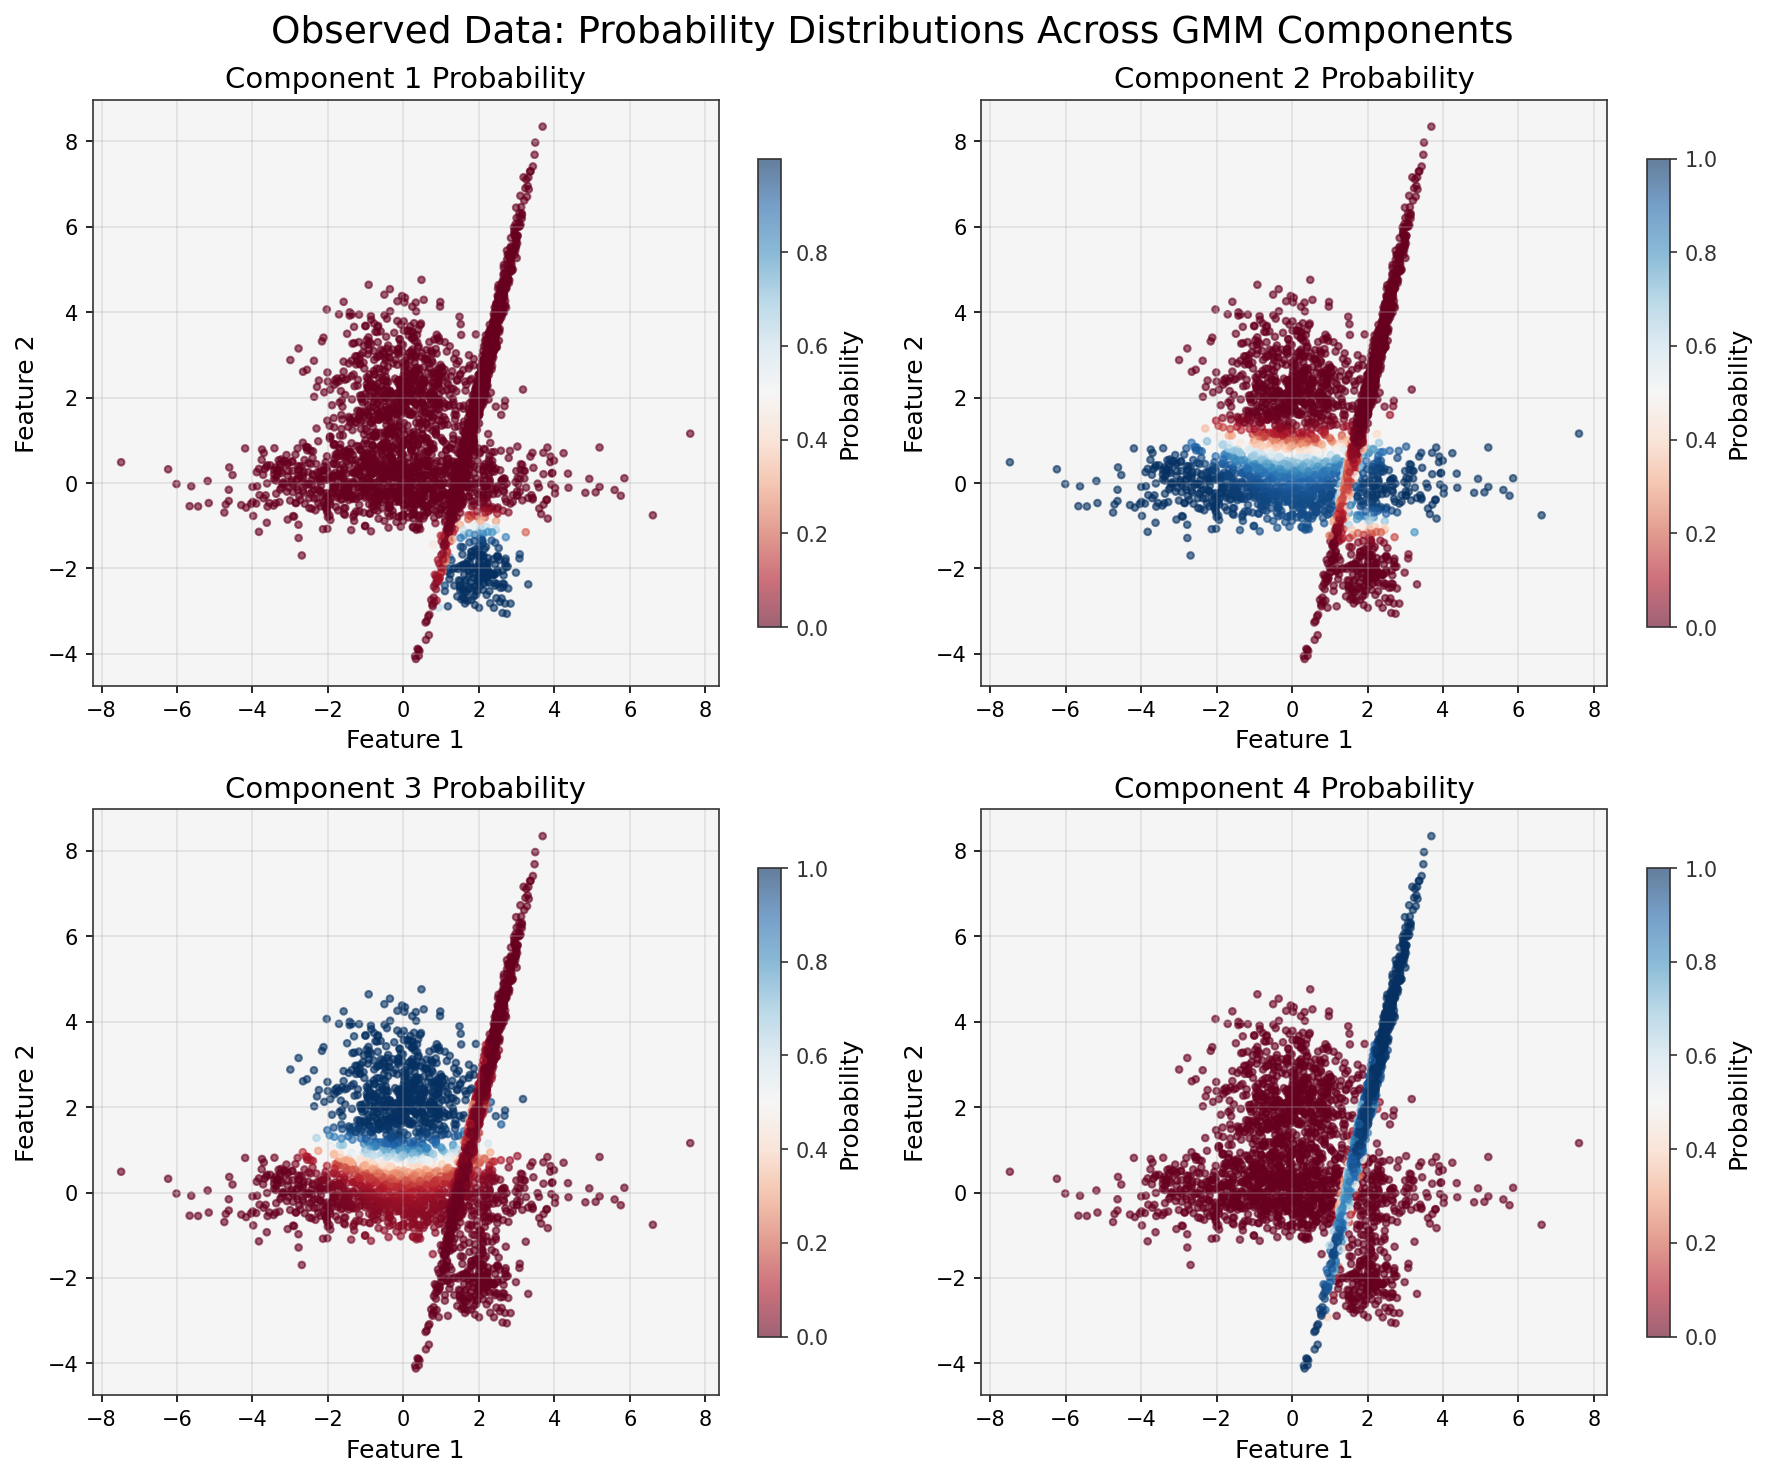

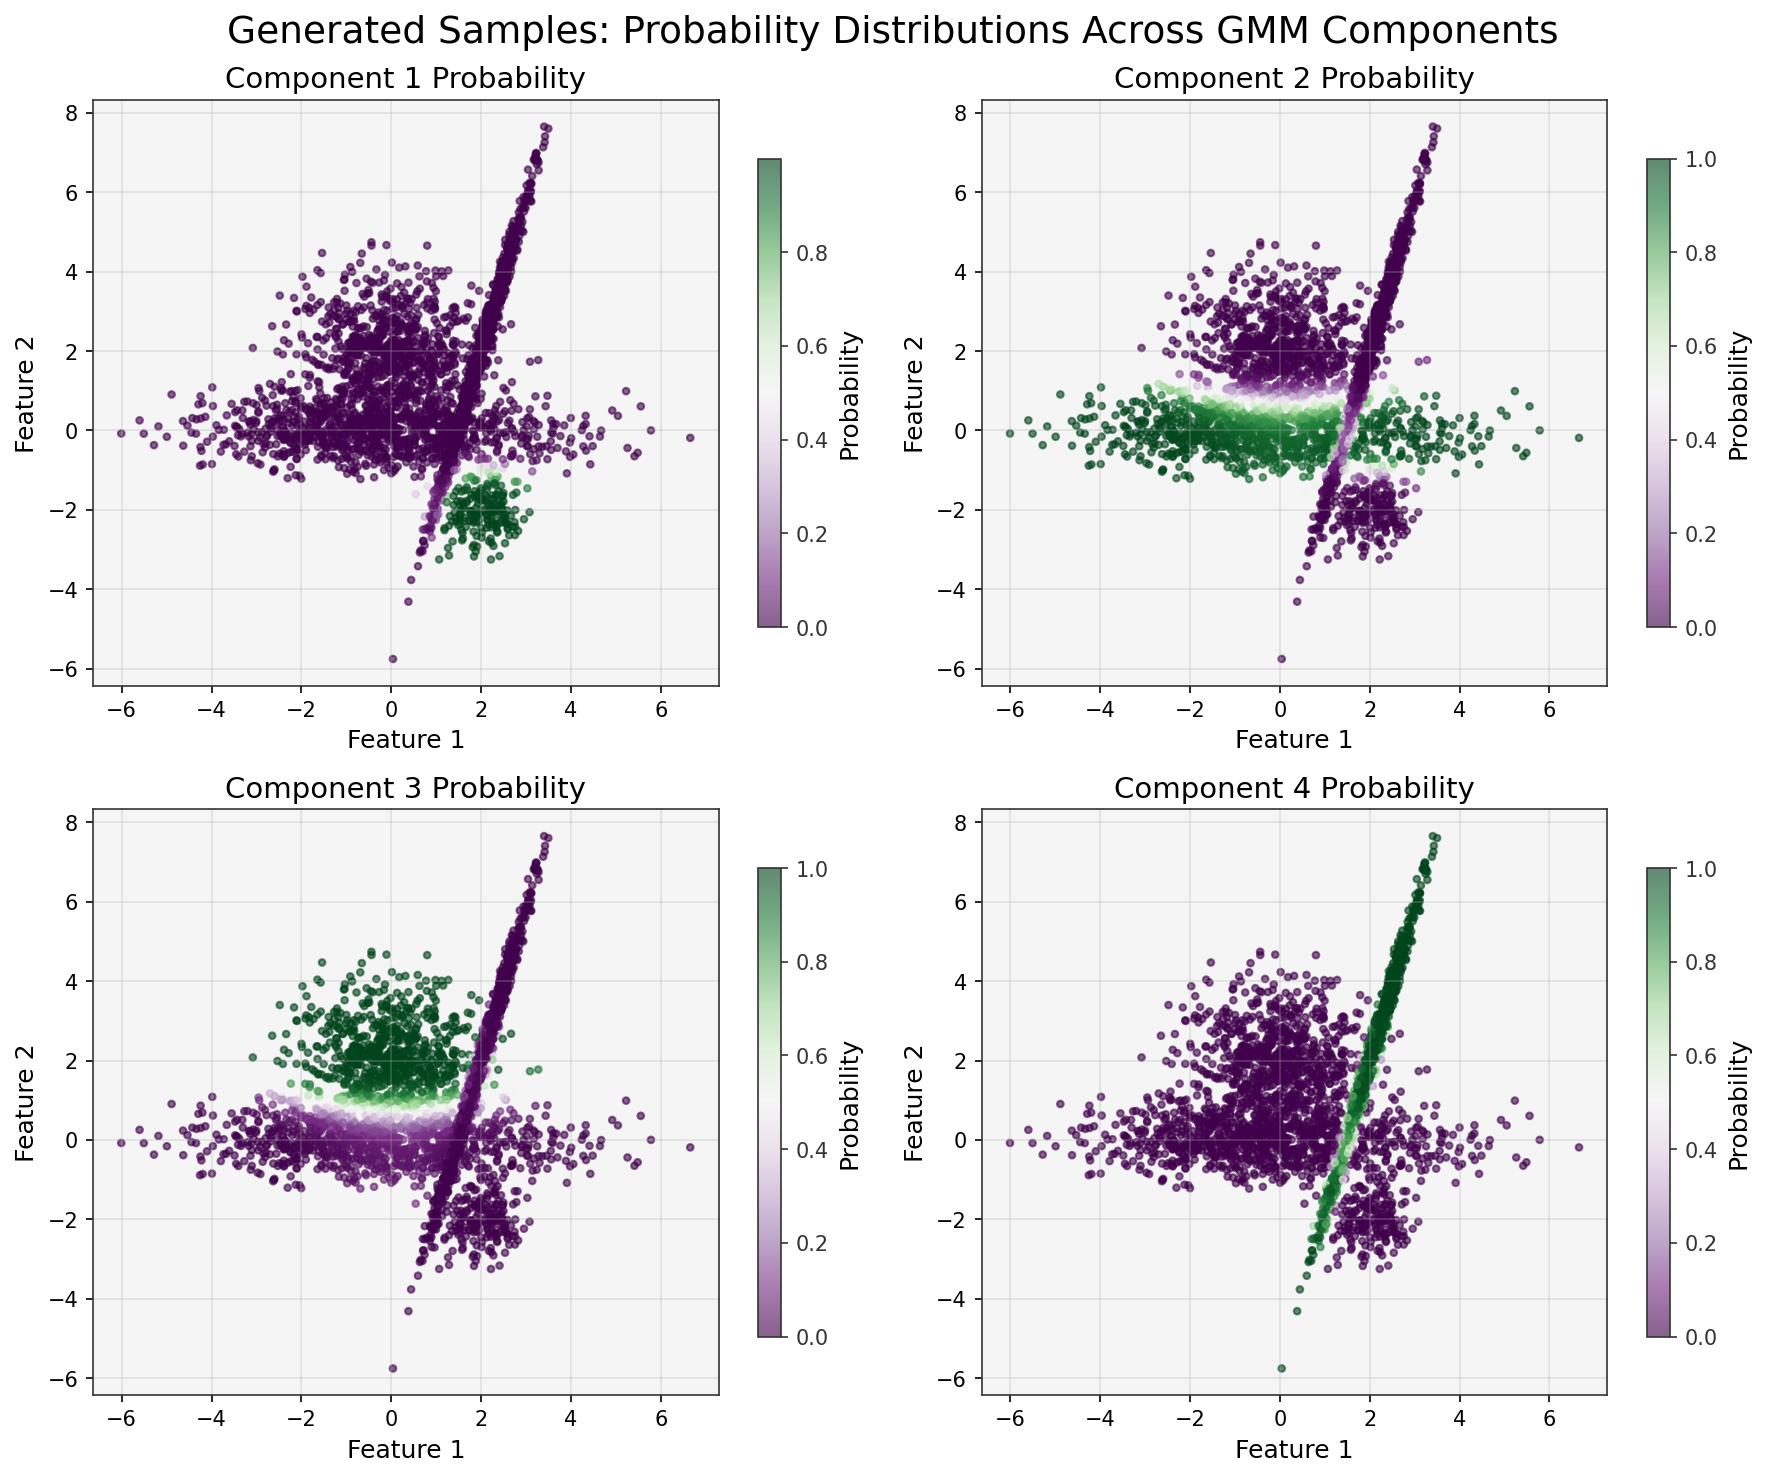

In [9]:
nrows, ncols = 2, 2
figsize = dynamic_figsize(nrows, ncols)

# Observed Data
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)

for k, ax in enumerate(axs.ravel()):
    # Assume probs is an array of shape (N, n_components)
    prob_k = probs[:, k]
    plot_gmm(X=X, ax=ax, title=f'Component {k+1} Probability', mode='continuous', color_values=prob_k, cmap_cont='RdBu', cbar_label='Probability')
plt.suptitle("Observed Data: Probability Distributions Across GMM Components")
plt.tight_layout()
plt.show()

# Generated Samples
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)

for k, ax in enumerate(axs.ravel()):
    prob_k = generated_probs[:, k]
    plot_gmm(X=gmm_samples, gmm=gmm, ax=ax, title=f'Component {k+1} Probability', mode='continuous', color_values=prob_k, cmap_cont='PRGn', cbar_label='Probability')
fig.suptitle("Generated Samples: Probability Distributions Across GMM Components")
plt.tight_layout()
plt.show()


---
## Comparing Different Covariance Types

In this section, we examine how the choice of covariance type affects the clustering results of the GMM. We consider six different covariance types:

- **Tied Spherical Covariance:**  
  All components share the same covariance matrix, which is spherical:
  $$
  \Sigma_1 = \Sigma_2 = \cdots = \Sigma_K = \sigma^2 I_d 
  = \sigma^2 \begin{bmatrix}
      1 & 0 & \cdots & 0 \\
      0 & 1 & \cdots & 0 \\
      \vdots & \vdots & \ddots & \vdots \\
      0 & 0 & \cdots & 1
  \end{bmatrix}.
  $$

- **Spherical Covariance:**  
  Each component $ k $ has its own spherical covariance matrix:
  $$
  \Sigma_k = \sigma_k^2 I_d 
  = \sigma_k^2 \begin{bmatrix}
      1 & 0 & \cdots & 0 \\
      0 & 1 & \cdots & 0 \\
      \vdots & \vdots & \ddots & \vdots \\
      0 & 0 & \cdots & 1
  \end{bmatrix}, \quad k = 1,\dots,K.
  $$

- **Tied Diagonal Covariance:**  
  All components share the same diagonal covariance matrix:
  $$
  \Sigma_1 = \Sigma_2 = \cdots = \Sigma_K =
  \begin{bmatrix}
      \sigma_1^2 & 0         & \cdots & 0 \\
      0         & \sigma_2^2 & \cdots & 0 \\
      \vdots    & \vdots    & \ddots & \vdots \\
      0         & 0         & \cdots & \sigma_d^2 
  \end{bmatrix}.
  $$

- **Diagonal Covariance:**  
  Each component $ k $ has its own diagonal covariance matrix:
  $$
  \Sigma_k =
  \begin{bmatrix}
      \sigma_{k1}^2 & 0            & \cdots & 0 \\
      0            & \sigma_{k2}^2 & \cdots & 0 \\
      \vdots       & \vdots       & \ddots & \vdots \\
      0            & 0            & \cdots & \sigma_{kd}^2
  \end{bmatrix}, \quad k = 1,\dots,K.
  $$

- **Tied Full Covariance:**  
  All components share the same full covariance matrix:
  $$
  \Sigma_1 = \Sigma_2 = \cdots = \Sigma_K = \Sigma =
  \begin{bmatrix}
      \sigma_{11} & \sigma_{12} & \cdots & \sigma_{1d} \\
      \sigma_{12} & \sigma_{22} & \cdots & \sigma_{2d} \\
      \vdots     & \vdots     & \ddots & \vdots \\
      \sigma_{1d} & \sigma_{2d} & \cdots & \sigma_{dd}
  \end{bmatrix}.
  $$

- **Full Covariance:**  
  Each component $ k $ has its own full covariance matrix:
  $$
  \Sigma_k =
  \begin{bmatrix}
      \sigma_{k11} & \sigma_{k12} & \cdots & \sigma_{k1d} \\
      \sigma_{k12} & \sigma_{k22} & \cdots & \sigma_{k2d} \\
      \vdots       & \vdots       & \ddots & \vdots \\
      \sigma_{k1d} & \sigma_{k2d} & \cdots & \sigma_{kdd}
  \end{bmatrix}, \quad k = 1,\dots,K.
  $$


For each covariance type, we:

1. Initialize a GMM with 4 components using k-means for mean initialization.
2. Fit the model to the dataset (converted to a PyTorch tensor, `X_tensor`).
3. Predict the cluster labels.
4. Visualize the clustering results with our custom `plot_gmm` function in a grid of subplots.

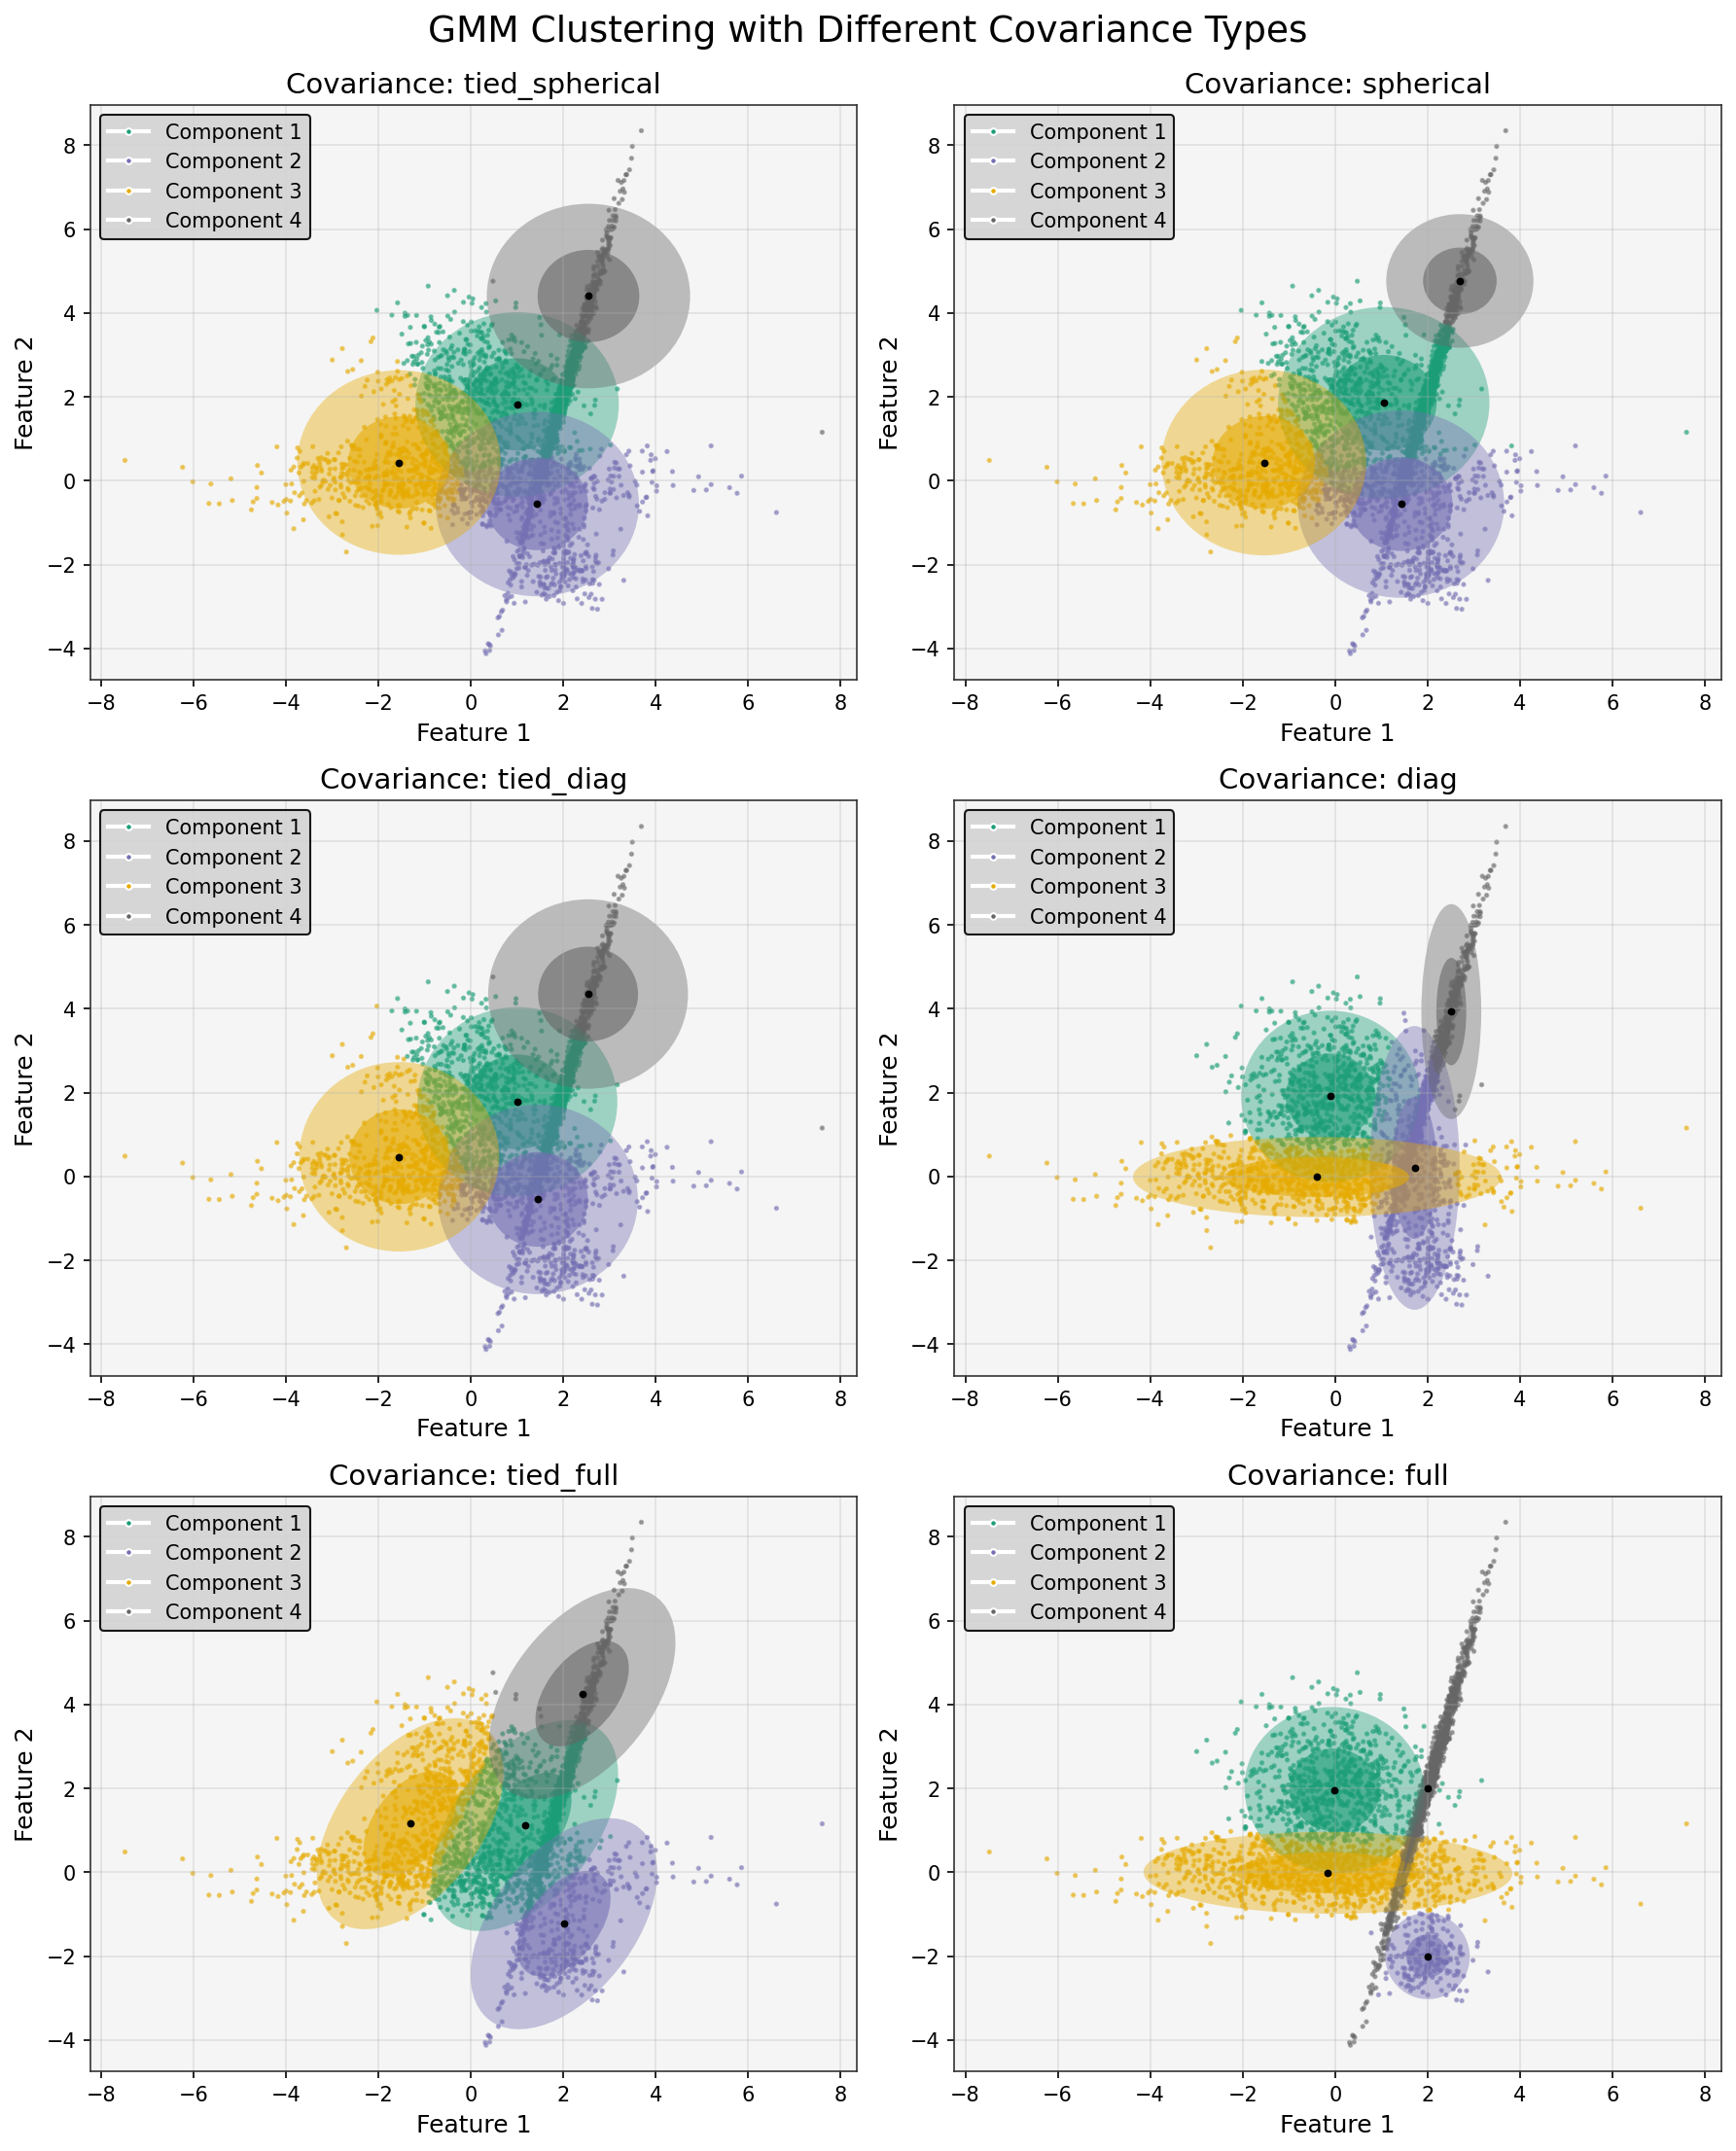

In [10]:
cov_types = ['tied_spherical', 'spherical', 'tied_diag', 'diag', 'tied_full', 'full']

torch.manual_seed(random_state)

nrows, ncols = 3, 2
figsize = dynamic_figsize(nrows, ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
axs = axs.flatten()

for ax, cov_type in zip(axs, cov_types):
    gmm = GaussianMixture(
        n_features=2,
        n_components=4,
        covariance_type=cov_type,
        init_params='kmeans',
        random_state=random_state,
        device=device
    )
    gmm.fit(X_tensor)
    labels_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(X, gmm=gmm, labels=labels_pred, ax=ax, title=f'Covariance: {cov_type}', legend_labels=legend_labels)

plt.suptitle("GMM Clustering with Different Covariance Types")
plt.tight_layout(rect=[0, 0, 1, 0.99])  # leave space for the suptitle
plt.show()

---
## Comparing Different Initialization Methods

In this section, we investigate how different initialization methods affect the GMM clustering results when using a fixed covariance type (here, **full**). The initialization methods compared are:

- **random**
- **points**
- **kpp** (k-means++)
- **kmeans**
- **maxdist**

Below, we provide a brief mathematical description of each method:

1. **Random Initialization**:  
   This method computes the empirical mean $\bar{x} $ and covariance $\Sigma$ of the dataset and then draws each initial center from a Gaussian distribution:
   $$
   \mu_i = \bar{x} + L z, \quad z \sim \mathcal{N}(0, I_d),
   $$
   where $ L $ is the Cholesky factor of $\Sigma$ (i.e. $\Sigma = LL^\top$).  
   This yields centers that roughly follow the global data distribution.

2. **Points Initialization**:  
   This method simply selects $ k $ points uniformly at random from the dataset. Mathematically, if $ S \subset \{1,2,\dots,N\} $ is a random subset of $ k $ indices, then:
   $$
   \mu_i = x_{s_i}, \quad i = 1, \dots, k.
   $$

3. **k-means++ Initialization (kpp)**:  
   The first center is chosen uniformly at random. For each subsequent center, the probability of selecting data point $ x_j $ is proportional to the square of its distance to the nearest already-chosen center:
   $$
   P(x_j) = \frac{D(x_j)}{\sum_{j=1}^{N} D(x_j)}, \quad \text{with } D(x_j) = \min_{l=1,\dots,i-1} \|x_j - \mu_l\|^2.
   $$
   This procedure tends to choose centers that are spread out.

4. **k-means Initialization**:  
   Starting from the k-means++ initialization, the standard k-means algorithm is run iteratively:
   - **Assignment step:**  
     Assign each point $ x_j $ to the nearest center:
     $$
     c_j = \arg\min_{i} \|x_j - \mu_i\|^2.
     $$
   - **Update step:**  
     Recompute each center as the mean of its assigned points:
     $$
     \mu_i = \frac{1}{|C_i|} \sum_{x_j \in C_i} x_j.
     $$
   These steps repeat until convergence (i.e. the centers do not change significantly).

5. **Max-Distance Initialization (maxdist)**:  
   This is a modified k-means++ method:
   - The first center is chosen randomly.
   - For $ i = 2,\dots,k $, choose the next center as:
     $$
     \mu_i = \arg\max_{x \in \mathcal{D}} \min_{l=1,\dots,i-1} \|x - \mu_l\|,
     $$
     ensuring that the new center is the point with the largest minimum distance to the existing centers.
   - Finally, the first center is reselected as the point with the largest distance from the centers $ \mu_2,\dots,\mu_k $:
     $$
     \mu_1 = \arg\max_{x \in \mathcal{D}} \min_{l=2,\dots,k} \|x - \mu_l\|.
     $$

For each initialization method, we obtain a set of initial means which are then passed (via the `means_init` parameter) to the GMM. This bypasses the model’s internal initialization logic, allowing us to compare the impact of different starting points on the final clustering.

1. Use a helper function (`get_init_means`) to obtain the initial means from the corresponding method.
2. Initialize a GMM with these precomputed initial means by providing them via the `means_init` parameter (thus bypassing the internal initialization logic).
3. Fit the GMM to the dataset (`X_tensor`).
4. Predict cluster labels and visualize the clustering results with our `plot_gmm` function, which also overlays the initial means (marked in red).

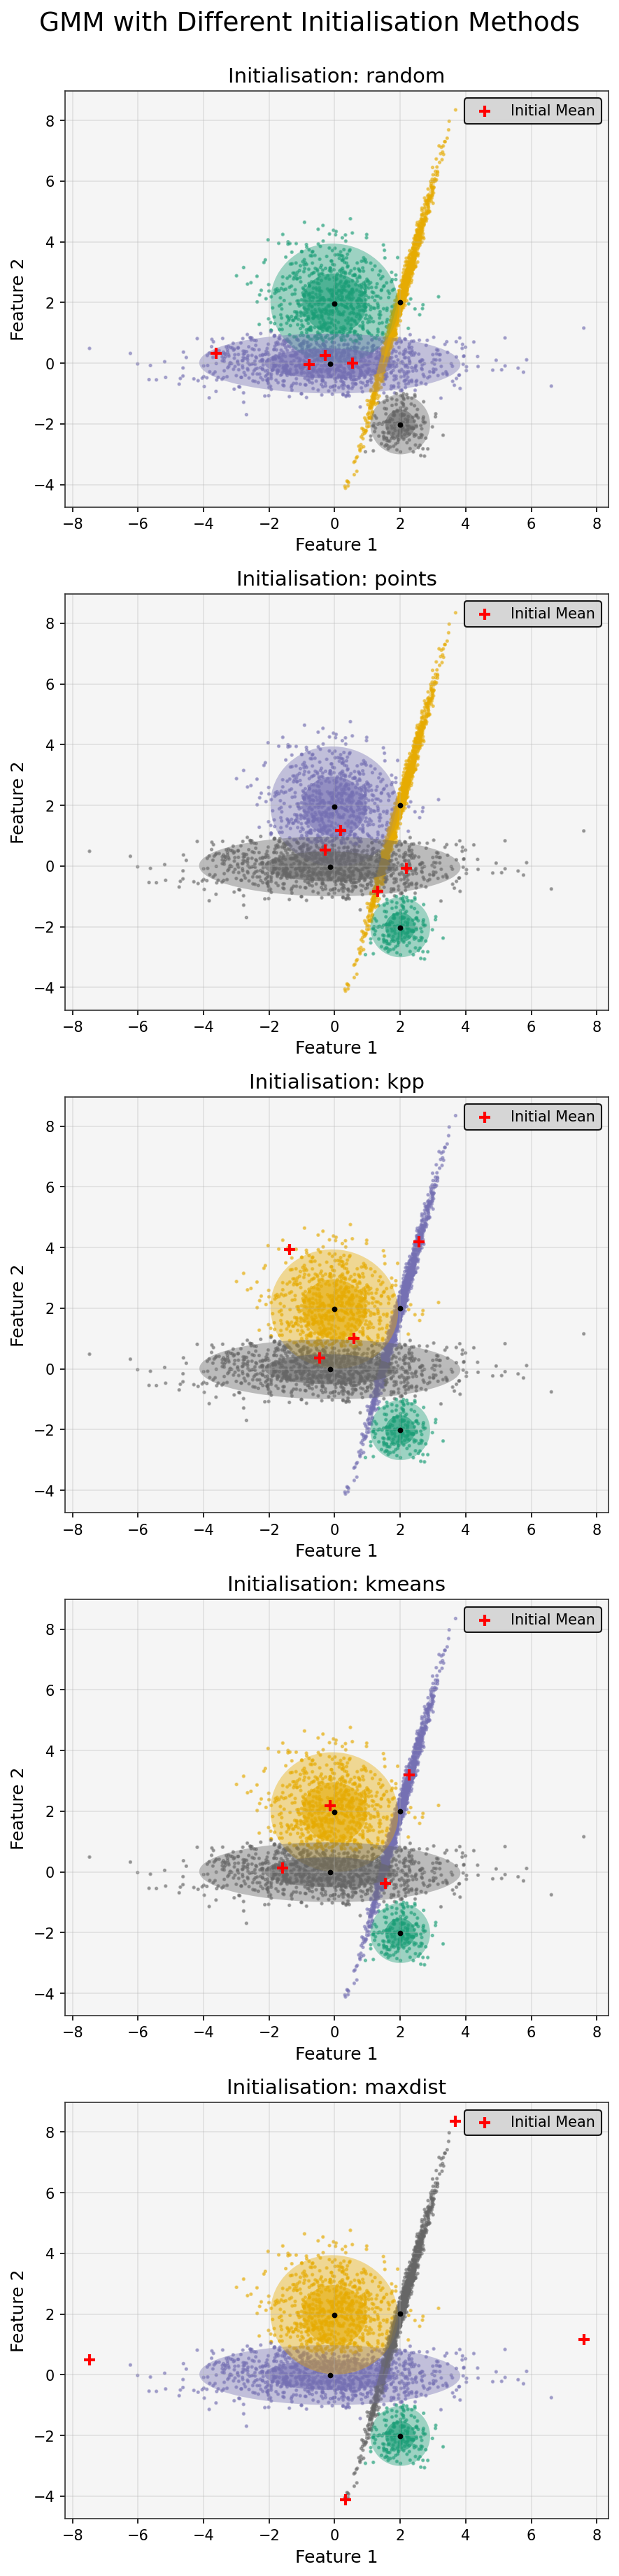

In [11]:
cov_types = ['full']
init_methods = ['random', 'points', 'kpp', 'kmeans', 'maxdist']

torch.manual_seed(random_state)

def get_init_means(method, data, k):
    """
    Returns initial means for a given method from GMMInitializer.
    """
    if method == 'random':
        return GMMInitializer.random(data, k)
    elif method == 'points':
        return GMMInitializer.points(data, k)
    elif method == 'kpp':
        return GMMInitializer.kpp(data, k)
    elif method == 'kmeans':
        return GMMInitializer.kmeans(data, k)
    elif method == 'maxdist':
        return GMMInitializer.maxdist(data, k)
    else:
        raise ValueError(f"Unknown init method: {method}")

nrows, ncols = len(init_methods), len(cov_types)
figsize = dynamic_figsize(nrows, ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=figsize)

for col_idx, method in enumerate(init_methods):
    ax = axs[col_idx]

    # 1) Get initial means from our GMMInitializer
    init_means = get_init_means(method, X_tensor, k=4)

    # 2) Create GMM with 'means_init' so it uses these means
    gmm = GaussianMixture(
        n_features=2,
        n_components=4,
        covariance_type=cov_types[0],
        means_init=init_means,
        init_params=None,      # or 'none' to bypass internal logic
        random_state=0,
        device=device,
        max_iter=1000,
        tol=1e-6,
        reg_covar=1e-10,
    )

    # 3) Fit the GMM on X_tensor
    gmm.fit(X_tensor)
    # 4) Predict cluster labels
    labels_pred = gmm.predict(X_tensor).cpu().numpy()

    # 5) Plot
    title = f'Initialisation: {method}'
    plot_gmm(X, gmm=gmm, labels=labels_pred, ax=ax, title=title, init_means=init_means, legend_labels=legend_labels)

plt.suptitle("GMM with Different Initialisation Methods")
plt.tight_layout(rect=[0, 0, 1, 0.98])  # leave space for the suptitle
plt.show()
